# End-to-end Pipeline for Predicting Classes from Synthetic Gene Expression Data

**Overview of Supervised Learning Pipelines in Python**

![A typical python supervised learning pipeline](figures/scikitlearn_simplified_pipeline.png "A Simplified Supervised
Machine Learning Pipeline in Python")

* After loading and preprocessing the data, one or several models are trained on the training data subset.
* During training, hyper-parameter optimization is performed to find the optimal algorithm
hyper-parameters using nested cross-validation (CV) for model validation.
* The trained model is then evaluated on unseen test data.

Dask thrives when computations are performed at the latest possible point in the pipeline,
so the visualizations in this notebook may lead to its performance appearing worse than it is. 

For a more detailed account of the performance of Dask and usage recommendations, confer the paper "Scalable
Transcriptomics Analysis with Dask: Applications in Data Science and Machine Learning".

All steps were conducted in Linux Ubuntu 22.04.1 LTS.

## Loading and pre-processing data
* First we must start up a Dask client.
* The associated Dask client dashboard for diagnostics is usually served at the address http://localhost:8787/status

In [1]:
from dask.distributed import Client
client = Client()
print(client)

/home/marta/IdeaProjectsVenvs/ML-DASK-TUTORIAL/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36545 instead
  warnings.warn(
2022-09-24 11:28:30,159 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tr7ubspm', purging
2022-09-24 11:28:30,159 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tbfq0m1_', purging
2022-09-24 11:28:30,160 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-yvb3od42', purging
2022-09-24 11:28:30,160 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-bjkgny1k', purging


<Client: 'tcp://127.0.0.1:35797' processes=4 threads=8, memory=15.47 GiB>


* Load the synthetic gene expression matrix and vector containing the respective class information.
* Every operation on a collection will generate as many tasks as there are partitions. Therefore,
we want our dask dataframes to have enough partitions to enable parallelization, but not so many as to
severely increase overhead.
* By loading the datasets as parquet files, we ensure that divisions, necessary for certain
downstream operations, are available and known.

In [2]:
import dask.dataframe as dd
import dask.array as da

feature_matrix = dd.read_parquet('n500_f8000_synthetic_features.parquet', engine='pyarrow')
class_vector = dd.read_parquet('n500_synthetic_labels.parquet', engine='pyarrow')

print("Number of genes:", feature_matrix.shape[1])
print("Number of samples:", class_vector.shape[0].compute())

Number of genes: 6000
Number of samples: 500


Visualize the frequency distribution of per-gene mean coding gene expression levels. Because most genes have a mean gene expression close to 0 with some very extreme outliers that lead to difficulties in visualization, we shift the figure's scale to be logarithmic in order to visualize expression levels by magnitude.

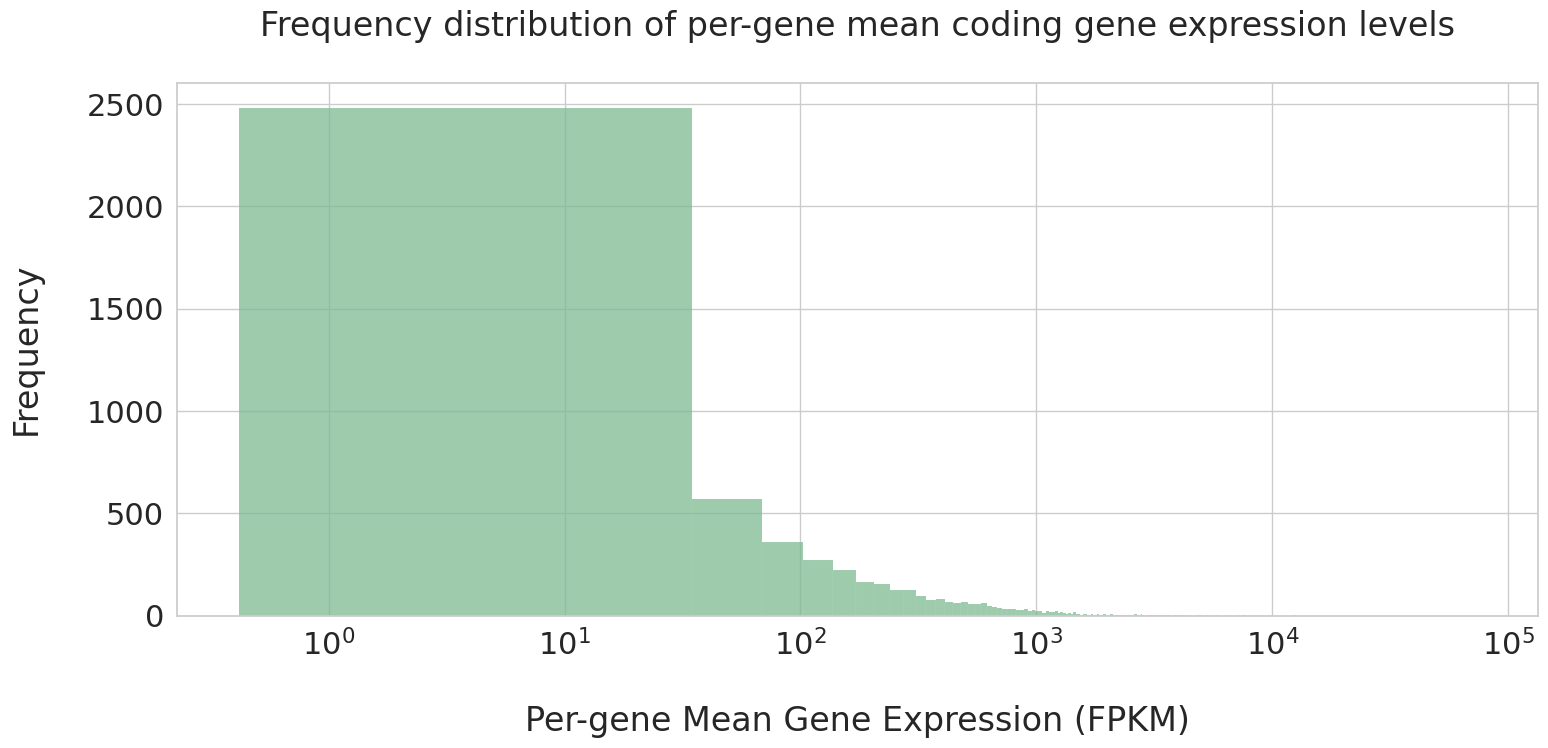

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(rc={'figure.figsize': (16, 8)}, style='whitegrid', font_scale=2, palette='crest')

ax = sns.histplot(feature_matrix.mean())
ax.set_xscale('log')
plt.xlabel("\nPer-gene Mean Gene Expression (FPKM)")
plt.ylabel("Frequency\n")
plt.title("Frequency distribution of per-gene mean coding gene expression levels\n")
plt.tight_layout()

Visualize the distribution of labels (synthetic classes A and B). Note the heavy class imbalance.

Text(0.5, 1.0, 'Distribution of labels (n = 500).')

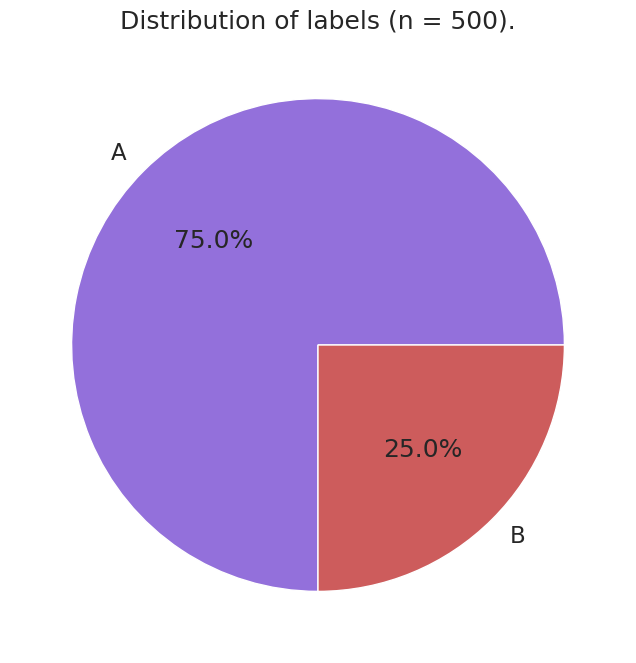

In [4]:
import numpy as np
%matplotlib inline

sns.set_theme(rc={'figure.figsize': (8, 8)}, style='whitegrid', font_scale=1.5, palette='crest')

labels, counts = np.unique(class_vector.values.compute(), return_counts=True)
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=["mediumpurple", "indianred", "limegreen", "deepskyblue",
                                                          "pink"])
plt.title(f"Distribution of labels (n = {counts.sum()}).")

Select genes with mean expression per gene higher than the 25th quartile of per-gene mean expression,
and variance higher than the 25th quartile of variance across samples.

In [5]:
gexp_mean = feature_matrix.mean(axis=0)
gexp_var = feature_matrix.var(axis=0)

feature_matrix_threshold = feature_matrix.loc[:,
                        feature_matrix.columns[(gexp_mean > gexp_mean.quantile(0.25) ) &
                                                 (gexp_var > gexp_var.quantile(0.25))]]

print("Number of genes after selecting genes with per-gene mean and variance higher than"
      "\nthe respective 25th quartiles:", feature_matrix_threshold.shape[1])

Number of genes after selecting genes with per-gene mean and variance higher than
the respective 25th quartiles: 4434


Next, we transform the feature matrix's data. For gene expression data, scale transformation usually consists in
log-scaling, which shifts the data from a linear scale into a logarithmic one, thereby reducing the range and
variance of the data.

In [6]:
feature_matrix_log = feature_matrix_threshold.applymap(lambda gene: da.log2(gene + 1))

Visualize the data distribution after log-scaling the coding gene expression data.

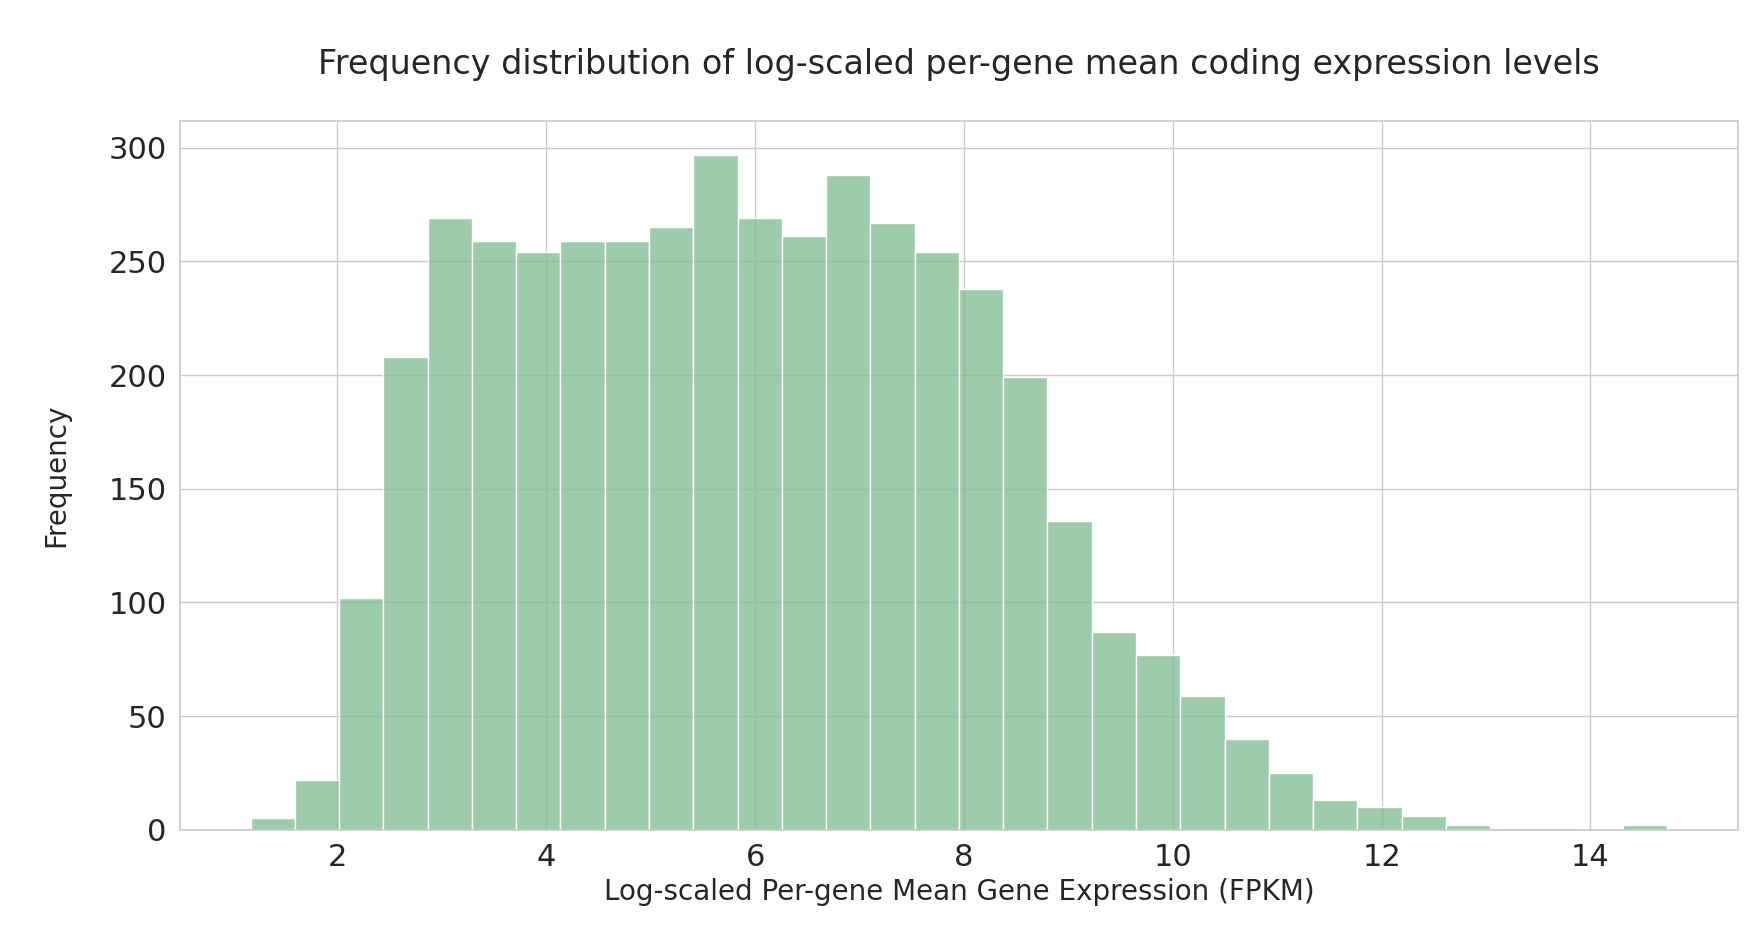

In [7]:
%matplotlib inline

sns.set_theme(rc={'figure.figsize': (16, 8)}, style='whitegrid', font_scale=2, palette='crest')

plt.figure(figsize=(18, 10))
ax = sns.histplot(feature_matrix_log.mean())
plt.xlabel("Log-scaled Per-gene Mean Gene Expression (FPKM)\n", fontsize=20)
plt.ylabel("\nFrequency\n", fontsize=20)
plt.title("\nFrequency distribution of log-scaled per-gene mean coding expression levels\n", fontsize=24)
plt.tight_layout()

* Afterwards, we perform sample scaling normalization on the gene expression data.
These methods consist in estimating scaling factors used to normalize expression levels across libraries.
* Specifically, we will apply Upper Quartile normalization on the data.

In [8]:
from functions.UpperQuartile import UpperQuartile

uq_norm = UpperQuartile(is_dask=True)
feature_matrix_norm = uq_norm.fit_transform(feature_matrix_log)

* Converting dask dataframes to dask arrays makes it easier to perform ML-related operations in Dask.
* For proper splitting into train/test sets, chunk sizes must be the same for both features and label datasets.

In [9]:
feature_array = feature_matrix_norm.to_dask_array(lengths=True).rechunk('auto')
classes_array = class_vector.to_dask_array(lengths=True).rechunk((feature_array.chunks[0], None))

* Before continuing, we have to split the gene expression feature matrix and classes label vector into
matching training and test sets. The proportion of samples to be assigned to the test set is 30%.
* In order to successfully split using dask, divisions must be known, and match for the two datasets.

In [10]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_array, classes_array,
                                                    test_size=0.3, shuffle=True, random_state=42)

print("Dimensions of the TRAINING feature matrix:", X_train.shape)
print("Dimensions of the TEST feature matrix:", X_test.shape)
print("Dimensions of the TRAINING classes vector:", y_train.shape)
print("Dimensions of the TEST classes vector:", y_test.shape)

Dimensions of the TRAINING feature matrix: (350, 4434)
Dimensions of the TEST feature matrix: (150, 4434)
Dimensions of the TRAINING classes vector: (350, 1)
Dimensions of the TEST classes vector: (150, 1)


* Encode the labels in both training and test vectors.
* After the final pre-ML processing step, we persist the resulting array to store them in memory. 
In this way, additional queries can be based on this in-memory data without repeating all preprocessing operations.


In [11]:
from dask_ml.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(y_train)
y_train_encoded, y_test_encoded = enc.transform(y_train), enc.transform(y_test)
y_train_encoded, y_test_encoded = da.ravel(y_train_encoded).persist(), da.ravel(y_test_encoded).persist()  # flatten label arrays

To finish pre-processing the gene expression data, we apply standardization to rescale the training set's features.
This allows the features to approximate a normal distribution with mean of 0 and a standard deviation of 1.

In [12]:
from dask_ml.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_scaled, X_test_scaled = sc.transform(X_train).persist(), sc.transform(X_test).persist()


* Visualize and calculate the effect of standardization.

Text(0.5, 1.0, 'Distribution of processed per-gene TRAINING mean expression levels')

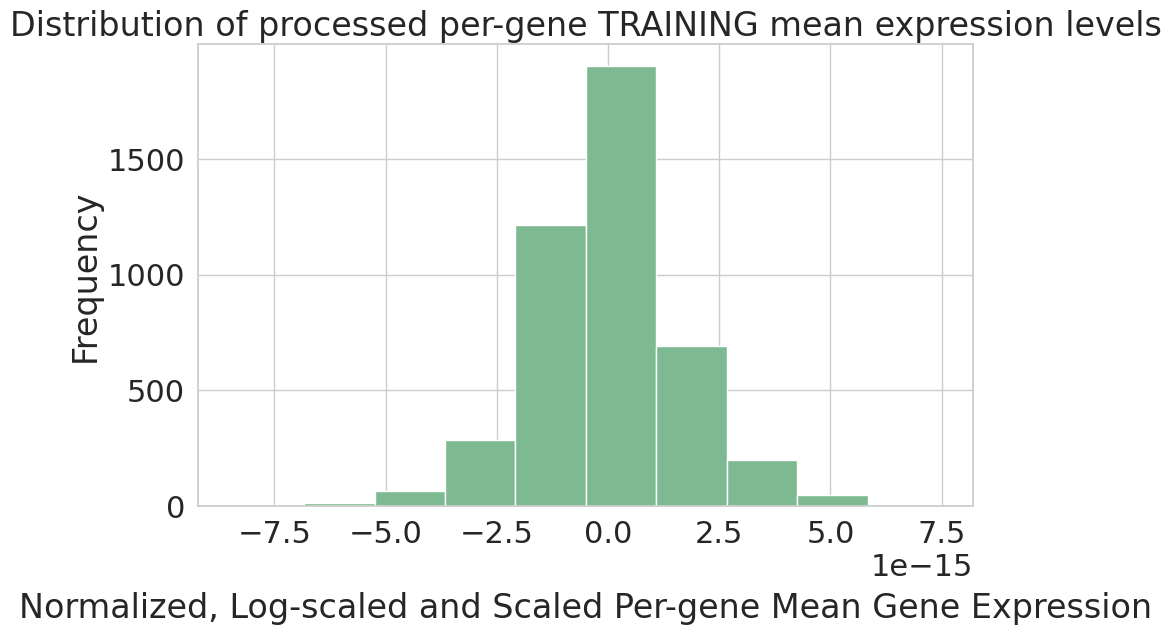

In [13]:
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(X_train_scaled.mean(axis=0).compute())
plt.xlabel("\nNormalized, Log-scaled and Scaled Per-gene Mean Gene Expression")
plt.ylabel("Frequency")
plt.title("Distribution of processed per-gene TRAINING mean expression levels")

Text(0.5, 1.0, 'Distribution of processed per-gene TEST mean expression levels')

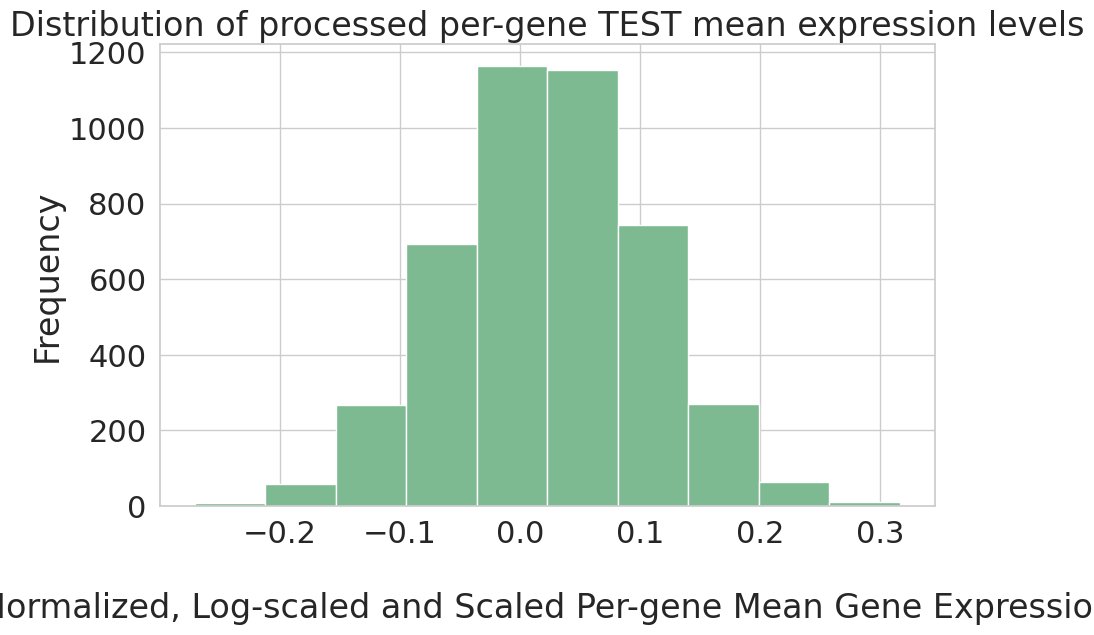

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(X_test_scaled.mean(axis=0).compute())
plt.xlabel("\nNormalized, Log-scaled and Scaled Per-gene Mean Gene Expression")
plt.ylabel("Frequency")
plt.title("Distribution of processed per-gene TEST mean expression levels")

In [15]:
print(f"Mean of per-mean TRAINING gene expression values: {X_train_scaled.mean(axis=0).mean().compute()} +/- {X_train_scaled.var(axis=0).var().compute()}")
print(f"Mean of per-mean TEST gene expression values: {X_test_scaled.mean(axis=0).mean().compute()} +/- {X_test_scaled.var(axis=0).var().compute()}")

Mean of per-mean TRAINING gene expression values: 4.8267356407957606e-18 +/- 7.5021512719756195e-31
Mean of per-mean TEST gene expression values: 0.024468145768829764 +/- 0.015039871057479504


## Machine Learning Model Training

* After data pre-processing, we can create machine learning models.
* This process involves choosing a machine learning algorithm to learn from the data's training subset (fit),
optionally optimizing said algorithm's hyper-parameters, validating the model on the training subset with
recursed to cross-validation, and performing a final evaluation on the untouched test subset.
* We start by deleting unneeded variables to reduce memory consumption:

In [16]:
import gc

del feature_matrix, class_vector, gexp_mean, gexp_var, feature_matrix_threshold, feature_matrix_log, \
    uq_norm, feature_matrix_norm, feature_array, classes_array, y_train, y_test, X_train, X_test

gc.collect()

492

### Simple Machine Learning Pipeline

* The simplest machine learning use-case is to fit the training data to an algorithm with default hyper-parameters.
* The trained model is validated with cross-validation (CV), customarily with 10 stratified folds.
* The model's final evaluation is performed on the untouched test set and compared against the validation
scores to detect model under- or over-fitting---respectively, when a model is not complex enough to fully capture
the training data, or too complex and well-fit to the training data to generalize to unseen cases.

Define a function to run a basic XGBoost pipeline with default hyper-parameters and CV = 10.

In [17]:
import xgboost as xgb
from dask_ml.metrics import accuracy_score
from functions.dask_cv import dask_cv

def dask_default_xgboost_pipeline(client: Client, X_train: da.Array, X_test: da.Array,
                                  y_train: da.Array, y_test: da.Array):

    bst = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    cv_scores = dask_cv(bst, X_train, y_train)
    mean_cv_score, std_cv_score = np.mean(cv_scores), np.var(cv_scores)

    bst = xgb.dask.DaskXGBClassifier(random_state=42, eval_metric='logloss')
    bst.client = client
    bst.fit(X_train, y_train)
    prediction = bst.predict(X_test)
    eval_score = accuracy_score(y_test, prediction)

    return mean_cv_score, std_cv_score, eval_score, bst, prediction

In [18]:
mean_cv_score, std_cv_score, eval_score, bst, y_pred = dask_default_xgboost_pipeline(client,
                                                                                     X_train_scaled, X_test_scaled,
                                                                                     y_train_encoded, y_test_encoded)

/home/marta/IdeaProjectsVenvs/ML-DASK-TUTORIAL/lib/python3.9/site-packages/xgboost/dask.py:884: RuntimeWarning: coroutine 'Client._wait_for_workers' was never awaited
  client.wait_for_workers(n_workers)
/home/marta/IdeaProjectsVenvs/ML-DASK-TUTORIAL/lib/python3.9/site-packages/distributed/worker_state_machine.py:3622: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[11:29:41] task [xgboost.dask-1]:tcp://127.0.0.1:46021 got new rank 0


To visualize the results, we can leverage a confusion matrix, where the diagonals correspond to correctly predicted
examples, and a classification report, showing how the classifier performs on a per-class basis.

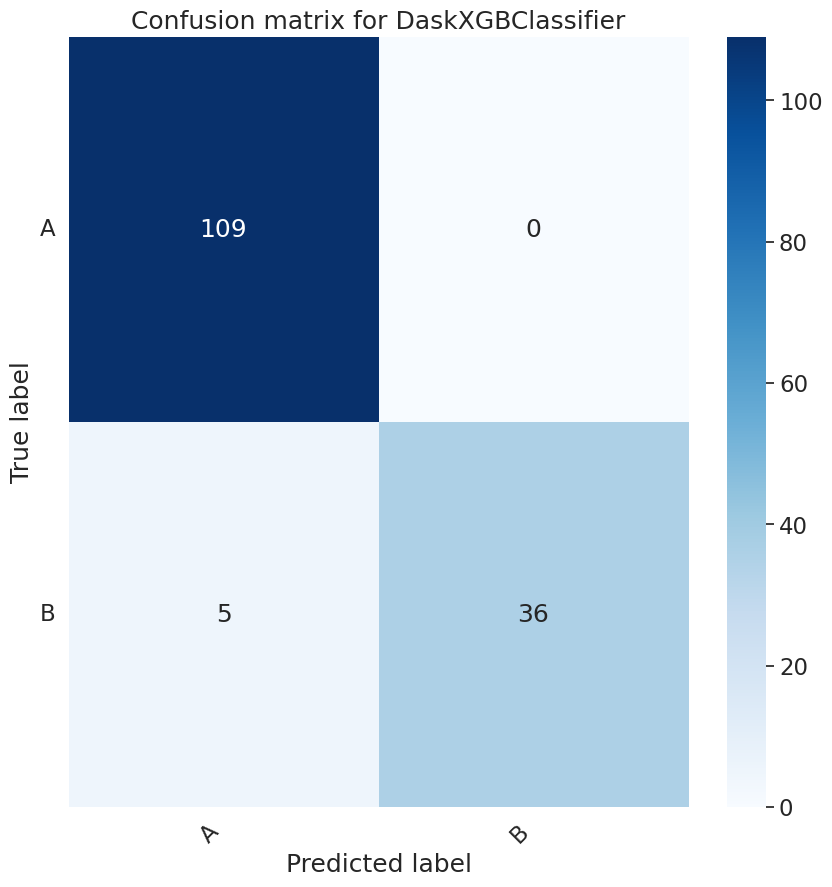

In [19]:
from functions.plots import plot_confusion_matrix
plot_confusion_matrix(bst, y_test_encoded, y_pred, enc)

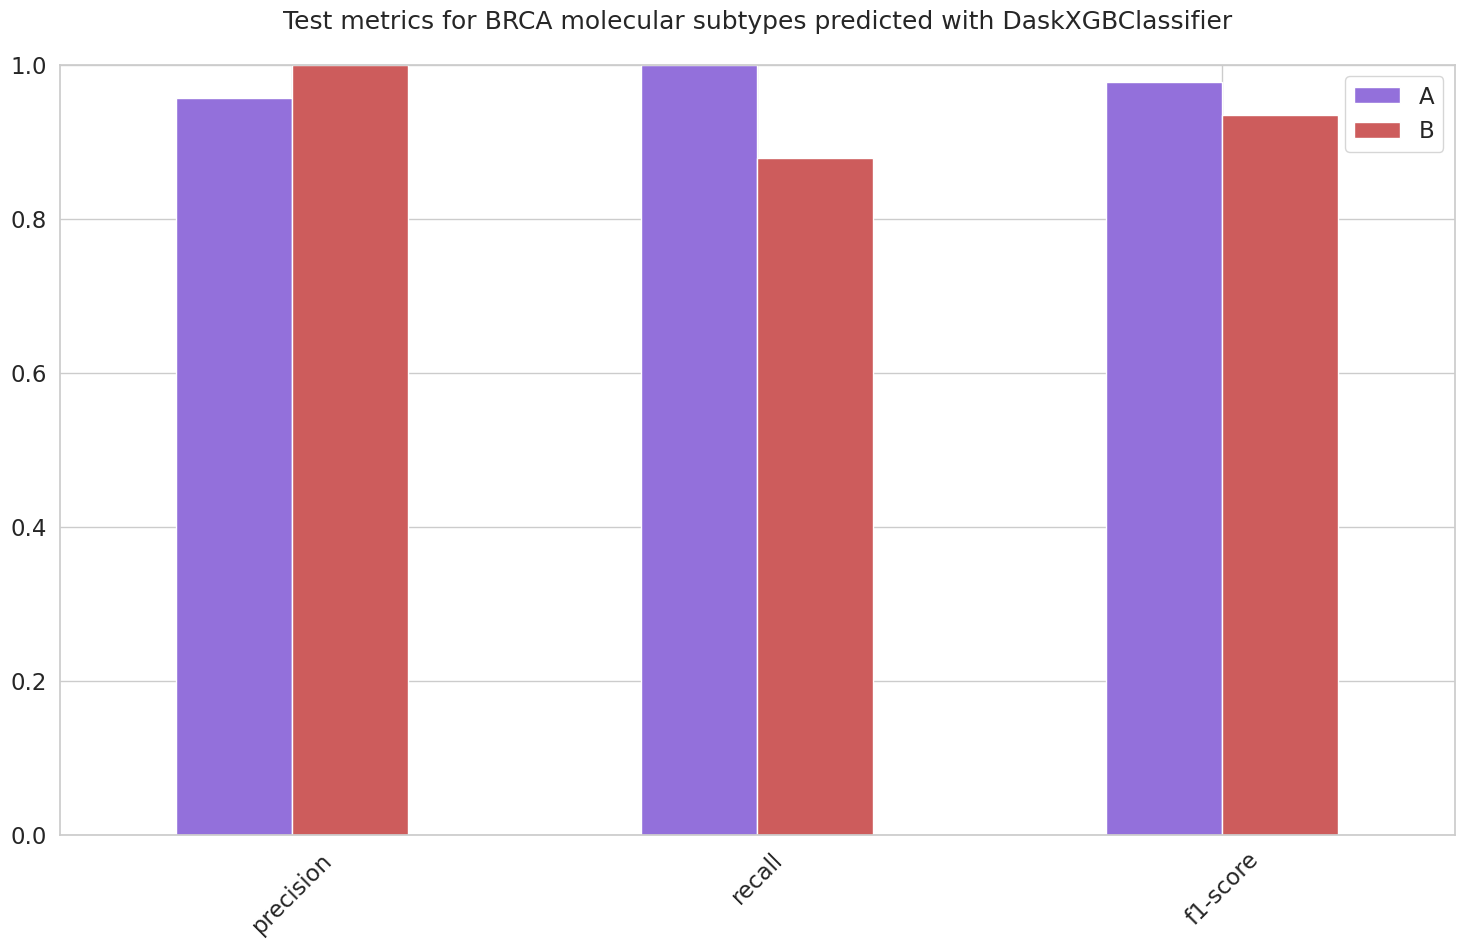

In [20]:
from functions.plots import plot_class_report
plot_class_report(bst, y_test_encoded, y_pred, enc)